# Textstellar 🌌

The `Textstellar` pipeline consists of two modules:

1. Semantic Ranking:
    - Given a conceptual definition for topic "X" (a list of "reference" sentences relating to X), find the top-k semantically related items.
    - We apply this to finding research outcomes (and researchers) that are most salient for a given excercise.

2. Topic Clustering:
    - Perform unsupervised clustering for topic discovery
    - Generate a 2D "night sky" visualization of topics

## Install packages

In [ ]:
from IPython.display import clear_output
!pip install bertopic
!pip install --upgrade joblib==1.1.0
!pip install --upgrade gensim
clear_output()

NB: If running on Colab, restart the runtime for the above packages to be loaded. Proceed with the cells below thereafter.

## Imports

In [1]:
import os
import ast
import torch
import random
import time
import json
import nltk
import math
import pickle
import warnings
import itertools
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer

from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

import plotly.express as px
import plotly.graph_objects as go

from typing import List

# additional installs
nltk.download('punkt')
warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize":(10, 14)}) #width=8, height=4
sns.set_style("ticks")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# mount google drive (for colab only)
from google.colab import drive
drive.mount('/content/drive')

## Global vars

In [2]:
SEED = 42
ROOT = '/content/drive/MyDrive/textstellar'

CHALLENGE_NAME = 'climate_change' # options: geopol_sec, thriving_communities
TITLE = " ".join(CHALLENGE_NAME.split('_')).upper()
MODEL_NAME = 'all-MiniLM-L6-v2' # options: all-distilroberta-v1, all-MiniLM-L6-v2

##################################Paths#########################################

MEAN_EMBED_PATH = f'{ROOT}/embeddings/{MODEL_NAME}_mean_sent_embeddings.npy'
SENT_EMBED_PATH = f'{ROOT}/embeddings/{MODEL_NAME}_sent_embeddings.pkl'
OUTPUT_SCORE_PATH = f'{ROOT}/outputs/{CHALLENGE_NAME}_match_scores_{MODEL_NAME}.csv'
OUTPUT_TOPIC_SCORES_PATH = f'{ROOT}/outputs/{CHALLENGE_NAME}_coherence_scores.csv'
OUTPUT_PLOT_PATH = f'{ROOT}/outputs/{CHALLENGE_NAME}_top_researchers.pdf'
OUTPUT_VIS_PATH = f'{ROOT}/outputs/{CHALLENGE_NAME}_topics.html'

#######################Topic Modeling Hyperparameters###########################
N_WORDS = 5
MAX_FEATURES = 5000
N_GRAM_RANGE = (1, 2)
TOKEN_PATTERN = r"\b[a-zA-Z_]{2,}\b"
N_COMPONENTS = 10 # UMAP reduced dimensions
# grids for hyperparameter tuning
MIN_CLUSTER_GRID_SIZE = [5, 10, 15, 20]
N_NEIGHBOURS_GRID_SIZE = [5, 10, 15, 20]
THRESHOLDS = [0.6, 0.7, 0.8, 0.9]

## Utils

In [3]:
#@title "Night Sky" Topic Visualizer
def visualize_documents(topic_model,
                        title,
                        if_list,
                        docs: List[str],
                        topics: List[int] = None,
                        embeddings: np.ndarray = None,
                        reduced_embeddings: np.ndarray = None,
                        sample: float = None,
                        hide_annotations: bool = False,
                        hide_document_hover: bool = False,
                        hover_text_labels: List[str] = None,
                        custom_labels: bool = False,
                        n_words: int = 6,
                        stop_words: List[str] = [],
                        template: str = 'simple_white',
                        info_text: str = 'Information here .. ',
                        width: int = 1200,
                        height: int = 750):
    
    topic_per_doc = topic_model.topics_

    # Sample the data to optimize for visualization and dimensionality reduction
    if sample is None or sample > 1:
        sample = 1

    indices = []
    for topic in set(topic_per_doc):
        s = np.where(np.array(topic_per_doc) == topic)[0]
        size = len(s) if len(s) < 100 else int(len(s) * sample)
        indices.extend(np.random.choice(s, size=size, replace=False))
    indices = np.array(indices)

    df = pd.DataFrame({"topic": np.array(topic_per_doc)[indices]})
    df["doc"] = [docs[index] for index in indices]
    df['doc_label'] = [hover_text_labels[index] for index in indices] # NB: added for hover text
    df['marker_size'] = [if_list[index] for index in indices] # NB: added for marker sizes
    df["topic"] = [topic_per_doc[index] for index in indices]

    # Extract embeddings if not already done
    if sample is None:
        if embeddings is None and reduced_embeddings is None:
            embeddings_to_reduce = topic_model._extract_embeddings(df.doc.to_list(), method="document")
        else:
            embeddings_to_reduce = embeddings
    else:
        if embeddings is not None:
            embeddings_to_reduce = embeddings[indices]
        elif embeddings is None and reduced_embeddings is None:
            embeddings_to_reduce = topic_model._extract_embeddings(df.doc.to_list(), method="document")

    # Reduce input embeddings
    if reduced_embeddings is None:
        umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings_to_reduce)
        embeddings_2d = umap_model.embedding_
    elif sample is not None and reduced_embeddings is not None:
        embeddings_2d = reduced_embeddings[indices]
    elif sample is None and reduced_embeddings is not None:
        embeddings_2d = reduced_embeddings

    unique_topics = set(topic_per_doc)
    if topics is None:
        topics = unique_topics

    # Combine data
    df["x"] = embeddings_2d[:, 0]
    df["y"] = embeddings_2d[:, 1]

    # Prepare text and names
    if topic_model.custom_labels_ is not None and custom_labels:
        names = [topic_model.custom_labels_[topic + topic_model._outliers] for topic in unique_topics]
    else:
        top_words = {topic: [word for word, value in topic_model.get_topic(topic) if word not in stop_words] for topic in unique_topics}
        names = [f"{topic}: " + ", ".join(top_words[topic][:n_words]) for topic in unique_topics]

    # Visualize
    fig = go.Figure()

    # Outliers and non-selected topics
    non_selected_topics = set(unique_topics).difference(topics)
    if len(non_selected_topics) == 0:
        non_selected_topics = [-1]

    selection = df.loc[df.topic.isin(non_selected_topics), :]
    selection["text"] = ""
    # Index(['topic', 'doc', 'doc_label', 'size', 'x', 'y', 'text'], dtype='object')
    selection.loc[len(selection), :] = [None, None, None, 5, selection.x.mean(), selection.y.mean(), "Other documents"]
    
    fig.add_trace(
        go.Scattergl(
            x=selection.x,
            y=selection.y,
            hovertext=selection.doc_label if not hide_document_hover else None,
            hoverinfo="text",
            mode='markers+text',
            name="other",
            showlegend=False,
            marker=dict(color='#CFD8DC', 
                        size=selection.marker_size.tolist(), 
                        # size=6,
                        opacity=0.5)
        )
    )

    # Selected topics
    for name, topic in zip(names, unique_topics):
        if topic in topics and topic != -1:
            selection = df.loc[df.topic == topic, :]
            selection["text"] = ""

            if not hide_annotations:
                selection.loc[len(selection), :] = [None, None, None, 5, selection.x.mean(), selection.y.mean(), name]

            fig.add_trace(
                go.Scattergl(
                    x=selection.x,
                    y=selection.y,
                    hovertext=selection.doc_label if not hide_document_hover else None,
                    hoverinfo="text",
                    text=selection.text,
                    mode='markers+text',
                    name=name,
                    textfont=dict(
                        size=12,
                    ),
                    marker=dict(
                                size=selection.marker_size.tolist(), # list of IFs + 5 to be sizes
                                # size=6,
                                opacity=0.5
                                )
                )
            )

    # Add grid in a 'plus' shape
    # x_range = (df.x.min() - abs((df.x.min()) * .15), df.x.max() + abs((df.x.max()) * .15))
    # y_range = (df.y.min() - abs((df.y.min()) * .15), df.y.max() + abs((df.y.max()) * .15))
    # fig.add_shape(type="line",
    #               x0=sum(x_range) / 2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
    #               line=dict(color="#CFD8DC", width=2))
    # fig.add_shape(type="line",
    #               x0=x_range[0], y0=sum(y_range) / 2, x1=x_range[1], y1=sum(y_range) / 2,
    #               line=dict(color="#9E9E9E", width=2))
    # fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text="D1", showarrow=False, yshift=10)
    # fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text="D2", showarrow=False, xshift=10)

    # Stylize layout
    fig.update_layout(
        template=template,
        title={
            'text': title,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="#f2f5fa") # Black or White
        },
        # width=width,
        # height=height
    )
    
    # colors = px.colors.qualitative.Pastel1
    # fig.update_traces(marker=dict(color=colors, 
    #                             #   line=dict(color='#000000', width=2)
    #                               )
    # )

    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)

    fig.add_annotation(x=0.98, y=0.01, showarrow=False, 
                       xref='paper', yref='paper', 
                       align='right', text=info_text)
    # fig.add_annotation(text='', 
    #                 align='left',
    #                 showarrow=False,
    #                 xref='paper',
    #                 yref='paper',
    #                 x=1.1,
    #                 y=0.8,
    #                 bordercolor='black',
    #                 borderwidth=1)
    return fig

In [93]:
def set_random_seeds(seed: int = 42):
    random.seed(seed) # python random seed
    np.random.seed(seed) # numpy random seed
    os.environ["PYTHONHASHSEED"] = str(seed)# environ seeds
    torch.manual_seed(seed) # pytorch seed
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

def save_embed(path, embeddings):
    with open(path, "wb") as outfile:
        pickle.dump({'embeddings': embeddings,
                    'encoder': MODEL_NAME},
                    outfile)

def load_embed(path):
    with open(path, "rb") as infile:
        cache_data = pickle.load(infile)
        embeddings = cache_data["embeddings"]
    
    return embeddings

def get_embeddings(corpus, model):
    start = time.time()
    embeddings = model.encode(corpus, show_progress_bar=True)
    print(embeddings.shape)
    print(f"Total time elapsed: {time.time() - start}")
    return embeddings

def join_sents(sents):
    if isinstance(sents, str):
        sents = ast.literal_eval(sents)
        
    # add punctuation to the title
    title = sents[0]
    if title.endswith('?') or title.endswith('.'):
        return " ".join(sents)
    else:
        sents[0] = f"{title}."
        return " ".join(sents)

def wordcloud(d, title, threshold=0.8, custom_stopwords=[]):
    stopwords = set(STOPWORDS)
    for word in custom_stopwords:
        stopwords.add(word) # custom
    
    rows = d[d.match_score > threshold].body.tolist()
    print(f"==> Rows selected: {len(rows)}")
    text = " ".join(rows).lower()
    wordcloud = WordCloud(width = 800, height = 800,
                    collocations = True,
                    prefer_horizontal=True,
                    background_color ='white',
                    stopwords = stopwords,
                    max_words=100,
                    min_font_size = 10).generate(text)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title)
    plt.show()

set_random_seeds(seed=SEED)

## Data

### Handcrafted prompt dimensions

GPT-3 or human-crafted sentences for creating concept reference vectors.

In [5]:
geopol_sec = [
    'Disruption to established institutional orders is undermining mechanisms for international security.',
    'Some conflicts are becoming increasingly intractable, with serious consequences for national, ethnic and religious groups.',
    'Digital disruption is causing widespread anxiety and mistrust in institutions and processes.',
    'Inequalities within nations are leading to other global forms of insecurity.',
    'The disruption of institutional orders is having a profound impact on international security.',
    'The intractability of some conflicts is exacerbating tensions between national, ethnic and religious groups.',
    'The digital age is challenging traditional ideas about sovereignty and security.',
    'The erosion of trust in institutions is leading to greater polarization and conflict.',
    'Inequalities within and between nations are fuelling social and political instability.',
    'The rise of new technologies is transforming the nature of warfare and security.',
    'The globalization of economic and social life is increasing the risks of conflict and instability.',
    'The spread of violent extremism is posing new challenges to security and stability.',
    'The increasing interconnectedness of the world is amplifying the impact of global insecurity.',
    'The rise of populism and nationalism is exacerbating tensions and conflict.',
    'The increasing number of refugees and migrants is putting pressure on social cohesion.',
    'The impact of climate change is adding to the sense of insecurity and instability.',
    'The proliferation of weapons of mass destruction is a major threat to international security.',
    'The growth of cyber-security threats is a new and increasingly serious challenge.',
    'The rise of China and other powers is changing the balance of power and leading to new tensions.',
    'The current international system is under strain and faces growing challenges.'
]

thriving_communities = [
    "Living in Communities concerns the interplay between people and communities with their urban environments and institutions, with a view to contributing to thriving communities through fostering agency, participation and empowerment with systems and infrastructures.", 
    "Living in Communities adopts a fundamentally place-based lens, understanding that this has both physical and virtual dimensions, as well as specific scales - from the individual scale, through to the metropolitan scale.",
    "Relevant domains of infrastructure include 'hard infrastructure' like housing, through to 'soft' infrastructure' like services.",
    "Places relates to the built (physical) environment and includes Housing and Employment, Suburbs & Neighbourhoods, Public Spaces, Amenities and Parks, Urban Design and Planning, Energy & Water,  Geographic/global location,  Ecology of Environment, Rural and Regional Environments.",
    "Networks relates to transport, technology & mobility and includes Mobility and Movement, Streets & Roads, Public Transport Infrastructure, Digital Connectivity.",
    "Governance relates to soft infrastructure & services and includes Services and Systems, Participation and Co-design, Digital Access, Forms of Governance, Civic Economy, Urban Design and Planning, Future Hospital, Crime Prevention, Gender Mainstreaming.",
    "Agency relates to inclusivity, accessibility & employment and includes Disability & Access, Arts, Festivals & Culture, Employment & Economy, Community Education, Sport."
]

climate_change = [
    "Climate changes now being generated and experienced threaten the fabric of our planet, and the quality of air, water and biodiversity that sustains us.",
    "Unchecked adverse consequences from climate change leads to natural disasters, issues of food and energy security, deteriorating planetary health for our human populations, disruption of habitats, and forced migrations of all living species.",
    "The impact of rising carbon emissions affects government policies (national and international), the shape of industry (locally and globally), and the way we work and live.",
    "Addressing the challenge of climate change requires new knowledge about its operation and solutions to its impacts, and accessing knowledge previously ignored or marginalised, as can be found in Indigenous knowledge and practices, such as those of Aboriginal and Torres Strait Islander peoples in Australia.",
    "The challenge of climate change will spawn new technologies, new skills and capabilities, and changes to behaviours and social and cultural patterns.",
    "Education to disseminate knowledge of climate change, to develop new capabilities and capacities, and to modify behavioural and social patterns will be vital to meeting the challenge and shaping the opportunities climate change provides.",
    "We should aim for a better-informed understanding of the nature and impacts of climate change on our environments and lives, for enhanced capabilities in our graduates to engage with these impacts in their work and their lives, and for new ideas and solutions about how we might prevent or mitigate detrimental effects and produce enhanced quality in our natural and created environments.",
    "The response to climate change requires deep commitment through our education and research to creating a more globally sustainable future, and to plotting the paths and possibilities to that end."
]

# NB: make sure the to select the correct phrase
if CHALLENGE_NAME == 'geopol_sec':
    ref_phrases = geopol_sec

elif CHALLENGE_NAME == 'thriving_communities':
    ref_phrases = thriving_communities

elif CHALLENGE_NAME == 'climate_change':
    ref_phrases = climate_change

else:
    raise ValueError

print(f"==> Selected challenge: {CHALLENGE_NAME}; Total reference phrases: {len(ref_phrases)}")

==> Selected challenge: climate_change; Total reference phrases: 8


### PURE dataset

In [6]:
df_abstracts = pd.read_excel(f'{ROOT}/data/Journal_Articles_2018-2021_Abstracts.xlsx')
df_authors = pd.read_excel(f'{ROOT}/data/Journal_Articles_2018-2021_Authors.xlsx')
df_outputs = pd.read_excel(f'{ROOT}/data/Journal_Articles_2018-2021_Outputs.xlsx')
df_abstracts.shape, df_authors.shape, df_outputs.shape

((38724, 2), (457143, 9), (39431, 26))

In [7]:
df_abstracts.head()

,Output UUID,Output Abstract
0,0b4455c1-2aba-49d8-ac96-bb8da364d847,A vertex colouring of a graph G is nonrepetiti...
1,5f340830-db81-4be6-9e49-19e3f58d0131,"Native fauna in species poor communities, such..."
2,1312e4e4-3387-4e68-8d4a-88701e595d5a,There is a growing body of evidence that early...
3,fc05fc25-5ad4-4266-b862-b1ba8d320661,The article analyses cross-generational negoti...
4,41827b9c-60a9-4955-ba49-fe39ff7db357,Negative news reporting in Australia about Afr...


In [8]:
df_authors.head()

,Output UUID,Author Order Number,Author Full Name,Author Type (At the time),Internal Author Org Unit (At the Time),Internal Author Org Unit - Primary (At the Time),Author External Org Name,External Org Country,External Org International Indicator
0,00014c0b-ea65-47e3-a18f-2899d6ed346f,1,"Gangadharan, Lata",Internal,Department of Economics,Dean Faculty of Business & Economics,NaN,NaN,NaN
1,00014c0b-ea65-47e3-a18f-2899d6ed346f,2,"Grossman, Philip Johnson",Internal,Department of Economics,Dean Faculty of Business & Economics,NaN,NaN,NaN
2,00014c0b-ea65-47e3-a18f-2899d6ed346f,2,"Grossman, Philip Johnson",Internal,NaN,NaN,University of Alaska Anchorage,United States of America,International
3,00014c0b-ea65-47e3-a18f-2899d6ed346f,3,"Jones, Kristy Marie",Internal,Department of Economics,Dean Faculty of Business & Economics,NaN,NaN,NaN
4,00014c0b-ea65-47e3-a18f-2899d6ed346f,4,"Leister, Christian Matthew",Internal,Department of Economics,Dean Faculty of Business & Economics,NaN,NaN,NaN


In [9]:
df_outputs.head()

,Output UUID,Output Year,Output Indicator - Research,Output Type,Output Subtype,Output Title,Output Bibliographic Text - Harvard,Output Keywords,ASJC Scopus Subject Areas,Administering Org Unit,...,Journal Citation Report (JCR) Q1,Output Indicator - Validated,Output Author Count - Internal,Output Author Count - External,Output Author Count - Total,Author List,Internal Author Org List,External Co-Authorship,External Author Org List (Limit 50),External Author Country List
0,00023b59-e868-4a51-95fc-c7854ccb101c,2021.0,Research,Contribution to journal,Article,Trends in adolescent alcohol and other risky h...,"Vashishtha, R, Pennay, A, Dietze, PM & Livings...",adolescent; adolescent health; alcohol consump...,Medicine (miscellaneous); Health(social science),Dept of Epidemiology & Prev Med Alf Hosp,...,NaN,Validated,1.0,3.0,4.0,"Vashishtha, Rakhi; Pennay, Amy; Dietze, Paul M...",Dept of Epidemiology & Prev Med Alf Hosp; Evid...,External Australian and International Co-Autho...,Curtin University; Duke-NUS Medical School Sin...,Australia; Singapore; Sweden
1,00050a44-0921-4436-bd66-db9ef7ca595a,2021.0,Research,Contribution to journal,Article,Cognitive profiles in patients with epileptic ...,"Dilcher, R, Malpas, CB, Walterfang, M, Kwan, P...",Anti-seizure medication; Cognition; Epilepsy; ...,Neurology; Clinical Neurology; Behavioral Neur...,Department of Neuroscience,...,NaN,Validated,4.0,2.0,7.0,"Dilcher, Roxane; Malpas, Charles B.; Walterfan...",Central Clinical Sch; Department of Neuroscience,External Australian Co-Authorship,Royal Melbourne Hospital; University of Melbourne,Australia
2,000813b0-7de8-41a0-9d83-54daedead7de,2021.0,Research,Contribution to journal,Article,"Adverse shocks, household expenditure and chil...","Trinh, T-A & Zhang, Q 2021, 'Adverse shocks, h...",Child marriage; Financial shocks; Household ex...,Statistics and Probability; Mathematics (misce...,Ctr for Health Economics,...,NaN,Validated,0.0,2.0,2.0,"Trinh, Trong-Anh; Zhang, Quanda",NaN,External Co-Authorship,Federation University Australia; RMIT University,Australia
3,0011ffd9-4f07-4a7c-ae69-6912ed1c32cd,2021.0,Research,Contribution to journal,Article,Experimental and numerical investigations of n...,"Lu, DX, Nguyen, NHT, Saleh, M & Bui, HH 2021, ...",Asphalt concrete; cohesive contact model; disc...,NaN,Civil Engineering,...,Q1,Validated,2.0,1.0,4.0,"Lu, Dai Xuan; Nguyen, Nhu H.T.; Saleh, Mofreh;...",Civil Engineering,External International Co-Authorship,University of Canterbury,New Zealand
4,0016cb1d-7cf5-4711-b46b-7f8215116f99,2021.0,Research,Contribution to journal,Article,Surgical management of pancreatic trauma in Au...,"Aldridge, O, Leang, YJ, Soon, DSC, Smith, M, F...",distal pancreatectomy; general surgery; hepato...,Surgery,Surgery Alfred Hospital,...,NaN,Validated,1.0,5.0,6.0,"Aldridge, Oscar; Leang, Yit J.; Soon, David S....",Surgery Alfred Hospital,External Australian Co-Authorship,Alfred Hospital; Fiona Stanley Hospital; Royal...,Australia


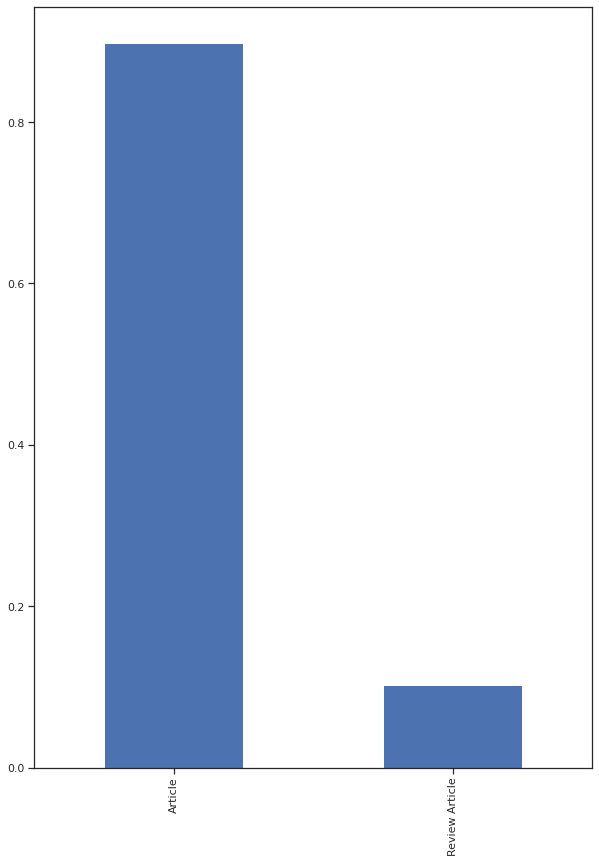

In [10]:
df_outputs['Output Subtype'].value_counts(normalize=True).plot(kind='bar');

## Exploring features

#### Check for `Not Specified` in abstracts

In [11]:
df_abstracts.isna().sum()

Output UUID        0
Output Abstract    0
dtype: int64

In [12]:
df_abstracts[df_abstracts['Output Abstract'] == 'Not Specified'].shape

(318, 2)

Set the `not specified` abstracts to empty ""

In [13]:
df_abstracts.loc[df_abstracts['Output Abstract'] == 'Not Specified', 'Output Abstract'] = ""

Sanity check

In [14]:
df_abstracts[df_abstracts['Output Abstract'] == 'Not Specified'].shape

(0, 2)

#### Check for duplicates in Titles

In [15]:
df_outputs.isna().sum()

Output UUID                              707
Output Year                              707
Output Indicator - Research              707
Output Type                              707
Output Subtype                           707
Output Title                             707
Output Bibliographic Text - Harvard      707
Output Keywords                         8931
ASJC Scopus Subject Areas               2908
Administering Org Unit                   707
Administering Org Unit - Primary         707
Output ID                                707
Scopus ID                               2257
Journal Title                            707
Journal ISSN List                        707
Journal Impact Factor - 2 Year          5052
Journal Citation Report (JCR) Q1       19548
Output Indicator - Validated             707
Output Author Count - Internal           707
Output Author Count - External           707
Output Author Count - Total              707
Author List                              707
Internal A

In [16]:
df_outputs.dropna(how='all', inplace=True)

In [17]:
df_outputs.isna().sum()

Output UUID                                0
Output Year                                0
Output Indicator - Research                0
Output Type                                0
Output Subtype                             0
Output Title                               0
Output Bibliographic Text - Harvard        0
Output Keywords                         8224
ASJC Scopus Subject Areas               2201
Administering Org Unit                     0
Administering Org Unit - Primary           0
Output ID                                  0
Scopus ID                               1550
Journal Title                              0
Journal ISSN List                          0
Journal Impact Factor - 2 Year          4345
Journal Citation Report (JCR) Q1       18841
Output Indicator - Validated               0
Output Author Count - Internal             0
Output Author Count - External             0
Output Author Count - Total                0
Author List                                0
Internal A

In [18]:
df_outputs.shape

(38724, 26)

In [19]:
# df_outputs.loc[df_outputs['Output Title'].duplicated(), 'Output Title'].unique()

In [20]:
df_outputs['_output_titles'] = df_outputs['Output Title'].str.lower()

In [21]:
df_counts = df_outputs._output_titles.value_counts().rename_axis('unique_values').reset_index(name='counts')
df_counts[df_counts.counts > 1].unique_values.tolist()

['review article',
 'the galah survey',
 'galaxy and mass assembly (gama)',
 'covid-19',
 'the gaia-eso survey',
 'brief report',
 'cohort profile',
 'the xxl survey',
 'randomised clinical trial',
 'the moyjil site, south-west victoria, australia',
 'image-based sexual abuse',
 'systematic review',
 'mind the gap',
 'convalescent plasma or hyperimmune immunoglobulin for people with covid-19',
 'primary aldosteronism',
 'technical note',
 'interventions for escalation of therapy for acute exacerbations of asthma in children',
 'systematic review and consensus definitions for the standardised endpoints in perioperative medicine (step) initiative',
 'review',
 'bridging the gap',
 'galaxy and mass assembly',
 'epidemiology and clinical features of emergency department patients with suspected covid-19',
 'not a care in the world',
 'systematic review and consensus definitions for the standardised endpoints in perioperative medicine initiative',
 'using three-dimensional image analysis tec

> Leave them as is (for now).

In [22]:
df_authors.isna().sum()

Output UUID                                              0
Author Order Number                                      0
Author Full Name                                         0
Author Type (At the time)                                0
Internal Author Org Unit (At the Time)              367311
Internal Author Org Unit - Primary (At the Time)    367311
Author External Org Name                            111494
External Org Country                                112491
External Org International Indicator                111494
dtype: int64

#### Join

In [23]:
df = df_abstracts.merge(df_outputs[['Output UUID', 'Output Title', 'Output Keywords']], on='Output UUID')
df.shape

(38724, 4)

In [24]:
df.head()

,Output UUID,Output Abstract,Output Title,Output Keywords
0,0b4455c1-2aba-49d8-ac96-bb8da364d847,A vertex colouring of a graph G is nonrepetiti...,Nonrepetitive Graph Colouring,NaN
1,5f340830-db81-4be6-9e49-19e3f58d0131,"Native fauna in species poor communities, such...",The impact of an invasive mud crab on brood su...,Baltic Sea; Benthic fish; Competition; Mud cra...
2,1312e4e4-3387-4e68-8d4a-88701e595d5a,There is a growing body of evidence that early...,Music value and participation,early childhood education; music development; ...
3,fc05fc25-5ad4-4266-b862-b1ba8d320661,The article analyses cross-generational negoti...,"My own business, not my children’s",cemetery; Chinese migrants; ethnic identities;...
4,41827b9c-60a9-4955-ba49-fe39ff7db357,Negative news reporting in Australia about Afr...,Overcoming the new kids on the block syndrome,NaN


#### Keywords

In [25]:
df['Output Keywords'].isna().sum() / df.shape[0]

0.2123747546741039

> 21% of `Output Keywords` are `NaN`. However, keywords in general could be used for evaluation of the topic modeling phase.

In [26]:
keywords = df['Output Keywords'].tolist()

Filter out NaNs and split each keyword

In [27]:
delimiter = ';'
keywords = [x.split(delimiter) for x in keywords if isinstance(x, str)]

In [28]:
keywords = list(itertools.chain(*keywords))

Case normalize and santize keywords

In [29]:
keywords = [x.lower().strip() for x in keywords]
print(len(keywords))

161238


In [30]:
count = Counter(keywords)
print(len(count))

73718


In [31]:
top_counts = count.most_common(150)

In [32]:
print(top_counts)

[('australia', 502), ('covid-19', 397), ('mental health', 313), ('systematic review', 307), ('depression', 282), ('stroke', 268), ('epidemiology', 250), ('inflammation', 241), ('obesity', 224), ('mortality', 211), ('meta-analysis', 211), ('quality of life', 209), ('rehabilitation', 203), ('qualitative research', 192), ('machine learning', 191), ('pregnancy', 181), ('cognition', 180), ('cancer', 179), ('anxiety', 173), ('education', 171), ('children', 170), ('breast cancer', 161), ('traumatic brain injury', 161), ('diabetes', 160), ('china', 158), ('physical activity', 155), ('dementia', 153), ('exercise', 152), ('public health', 147), ('hiv', 136), ('gender', 136), ('hadron-hadron scattering (experiments)', 133), ('malaysia', 131), ('climate change', 130), ('prevention', 125), ('qualitative', 123), ('risk factors', 123), ('trauma', 117), ('deep learning', 116), ('sleep', 116), ('older adults', 115), ('treatment', 115), ('social media', 115), ('hypertension', 113), ('alcohol', 113), ('e

## Semantic similarity

### Model selection

In [33]:
# for other models, check: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer(MODEL_NAME)
MAX_SEQ_LENGTH = model.max_seq_length
print(MAX_SEQ_LENGTH)

256


### Sequence length

#### Body

Combine title and abstract

In [34]:
df['body'] = df.apply(lambda x: f"{x['Output Title']}. {x['Output Abstract']}", axis=1)
df['body'] = df.body.str.strip()

In [35]:
df.iloc[25].body

'Dimensions of consciousness and the psychedelic state. It has often been suggested in the popular and academic literature that the psychedelic state qualifies as a higher state of consciousness relative to the state of normal waking awareness. This article subjects this proposal to critical scrutiny, focusing on the question of what it would mean for a state of consciousness to be ‘higher’. We begin by considering the contrast between conscious contents and conscious global states. We then review the changes in conscious global state associated with psychedelic drug use, focusing on the effects of two serotonergic hallucinogens: psilocybin and lysergic acid diethylamide. Limiting our review to findings obtained from lab-based experiments and reported in peer-reviewed journals, we prioritize the more common and reliably induced effects obtained through subjective questionnaires and psychophysical measures. The findings are grouped into three broad categories (sensory perception, cognit

In [36]:
df['seq_length'] = df.body.apply(len)
print(df.seq_length.max(), df.seq_length.min())

3278 6


In [37]:
df.seq_length.describe()

count    38724.000000
mean      1578.931025
std        527.783847
min          6.000000
25%       1213.000000
50%       1568.000000
75%       1898.000000
max       3278.000000
Name: seq_length, dtype: float64

In [38]:
# coverage
print(f"==> Rows that are fit the max sequence length: {df[df['seq_length'] <= model.max_seq_length].shape[0] / df.shape[0] * 100:.4f}%")

==> Rows that are fit the max sequence length: 0.8728%


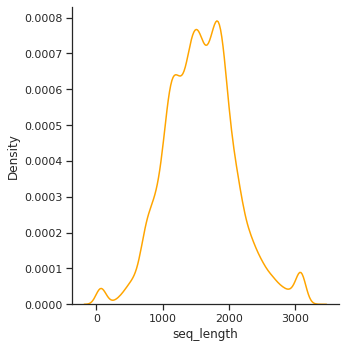

In [39]:
sns.displot(data=df, 
            x="seq_length", 
            color='orange',
            kind='kde'
           );

Split into component sentences

In [40]:
df['sent'] = df['Output Abstract'].apply(lambda x: nltk.sent_tokenize(x))

Prepend `title`

In [41]:
df['sent'] = df.apply(lambda x: [x['Output Title']] + x['sent'], axis=1)

In [42]:
print("\n".join(df.iloc[0].sent))

Nonrepetitive Graph Colouring
A vertex colouring of a graph G is nonrepetitive if G contains no path for which the first half of the path is assigned the same sequence of colours as the second half.
Thue's famous theorem says that every path is nonrepetitively 3-colourable.
This paper surveys results about nonrepetitive colourings of graphs.
The goal is to give a unified and comprehensive presentation of the major results and proof methods, as well as to highlight numerous open problems.


In [43]:
df_sent = df.explode(column='sent', ignore_index=True) # explode the chunks

In [44]:
df_sent.head()

,Output UUID,Output Abstract,Output Title,Output Keywords,body,seq_length,sent
0,0b4455c1-2aba-49d8-ac96-bb8da364d847,A vertex colouring of a graph G is nonrepetiti...,Nonrepetitive Graph Colouring,NaN,Nonrepetitive Graph Colouring. A vertex colour...,493,Nonrepetitive Graph Colouring
1,0b4455c1-2aba-49d8-ac96-bb8da364d847,A vertex colouring of a graph G is nonrepetiti...,Nonrepetitive Graph Colouring,NaN,Nonrepetitive Graph Colouring. A vertex colour...,493,A vertex colouring of a graph G is nonrepetiti...
2,0b4455c1-2aba-49d8-ac96-bb8da364d847,A vertex colouring of a graph G is nonrepetiti...,Nonrepetitive Graph Colouring,NaN,Nonrepetitive Graph Colouring. A vertex colour...,493,Thue's famous theorem says that every path is ...
3,0b4455c1-2aba-49d8-ac96-bb8da364d847,A vertex colouring of a graph G is nonrepetiti...,Nonrepetitive Graph Colouring,NaN,Nonrepetitive Graph Colouring. A vertex colour...,493,This paper surveys results about nonrepetitive...
4,0b4455c1-2aba-49d8-ac96-bb8da364d847,A vertex colouring of a graph G is nonrepetiti...,Nonrepetitive Graph Colouring,NaN,Nonrepetitive Graph Colouring. A vertex colour...,493,The goal is to give a unified and comprehensiv...


In [45]:
# recompute seq_length
df_sent['seq_length'] = df_sent.sent.apply(len)

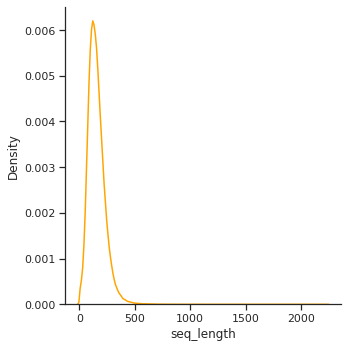

In [46]:
sns.displot(data=df_sent, 
            x="seq_length", 
            color='orange',
            kind='kde'
           );

Sanity check

In [47]:
# coverage
print(f"==> Rows that are fit the max sequence length: {df_sent[df_sent['seq_length'] <= model.max_seq_length].shape[0] / df_sent.shape[0] * 100:.4f}%")

==> Rows that are fit the max sequence length: 91.2477%


Note:
- 91% of sentences are covered with `MiniLM`
- Almost all (~99%) of sentences are covered with `all-distilroberta-v1`
- However, `MiniLM` is faster and better in terms of computing embeddings for semantic similarity.

### Generate Embeddings

In [48]:
corpus = df_sent.sent.tolist()
sents = dict(zip(df['Output UUID'], df['sent']))
print(len(corpus))

392836


In [49]:
if not os.path.exists(SENT_EMBED_PATH):
    # might take a while -- one off job; load from cache later
    research_embeddings = get_embeddings(corpus, model)
    save_embed(path=SENT_EMBED_PATH, embeddings=research_embeddings)

else:
    # load pre-cache embeddings
    print(f"==> Embedding cache exists under {SENT_EMBED_PATH} .. loading .. ")
    research_embeddings = load_embed(path=SENT_EMBED_PATH)

print(research_embeddings.shape)

==> Embedding cache exists under /content/drive/MyDrive/textstellar/embeddings/all-MiniLM-L6-v2_sent_embeddings.pkl .. loading .. 
(392836, 384)


Generate (reference) vectors

In [50]:
ref_embeddings = model.encode(ref_phrases)
print(ref_embeddings.shape)

(8, 384)


### Aggregated vectors

Get mean pooled vectors of sentences for each unique UUID. 

In [51]:
uuids = df_sent['Output UUID'].unique().tolist()
print(len(uuids))

38724


In [52]:
if not os.path.exists(MEAN_EMBED_PATH):
    # might take a while -- one off job; load from cache later
    agg_vectors = []
    for uuid in uuids:
        idxs = df_sent.loc[df_sent['Output UUID'] == uuid].index.tolist()
        mean_vec = np.expand_dims(research_embeddings[idxs, :].mean(axis=0), axis=0)
        agg_vectors.append(mean_vec)
    
    agg_vectors = np.concatenate(agg_vectors, axis=0)
    np.save(MEAN_EMBED_PATH, agg_vectors) # save
    
else:
    # load pre-cache embeddings
    print(f"==> Embedding cache exists under {MEAN_EMBED_PATH} .. loading .. ")
    agg_vectors = np.load(MEAN_EMBED_PATH)

print(agg_vectors.shape)

==> Embedding cache exists under /content/drive/MyDrive/textstellar/embeddings/all-MiniLM-L6-v2_mean_sent_embeddings.npy .. loading .. 
(38724, 384)


Compute distances with cosine similarity

In [53]:
distances = cosine_similarity(agg_vectors, ref_embeddings)
distances.shape

(38724, 8)

Add across all reference vector/dimensions for each research output

In [54]:
dist_sum = distances.sum(1)
print(dist_sum.max(), dist_sum.min())

5.018741 -1.451364


Normalize to be between `[0,1]`

In [55]:
dist_norm = (dist_sum - dist_sum.min()) / (dist_sum.max() - dist_sum.min())
print(dist_norm.max(), dist_norm.min())

1.0 0.0


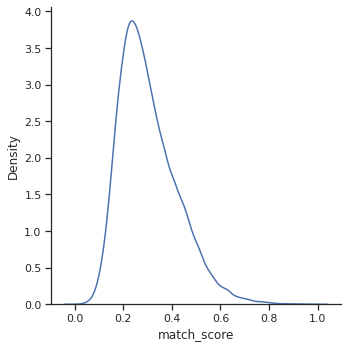

In [56]:
df['match_score'] = list(dist_norm)
df.match_score.describe()
sns.displot(data=df,
            x="match_score", 
            kind='kde'
           );

In [57]:
df.sort_values(by=['match_score'], ascending=False, inplace=True) # sort
df.to_csv(OUTPUT_SCORE_PATH, index=False)
print(f"==> Match scores exported successfully under: {OUTPUT_SCORE_PATH}")

==> Match scores exported successfully under: /content/drive/MyDrive/textstellar/outputs/climate_change_match_scores_all-MiniLM-L6-v2.csv


In [58]:
df.head(10) # sanity check; top 10 matches

,Output UUID,Output Abstract,Output Title,Output Keywords,body,seq_length,sent,match_score
38216,9f45a6bb-2921-401e-99f9-d199f57bab54,Climate change is a key societal and economic ...,A multilevel analysis of climate change inaction,Adaptive cycle; business model transformation;...,A multilevel analysis of climate change inacti...,1480,[A multilevel analysis of climate change inact...,1.000000
17403,5f098dc2-09b5-4107-b441-fb18843d7cfe,Changes in natural hazards related to climate ...,"A conceptual framework for climate change, hea...",NaN,"A conceptual framework for climate change, hea...",1404,"[A conceptual framework for climate change, he...",0.953132
9427,bb83a076-d66b-4ef6-a05f-c7aff034c0d5,"Increasing discussion is occurring, in both th...",The risk of catastrophic climate change,BECCS; Catastrophic climate change; Climate em...,The risk of catastrophic climate change. Incre...,1008,"[The risk of catastrophic climate change, Incr...",0.950208
31841,a86083cb-3e92-4a4e-b86d-efe1d7a3fbce,Climate plays an important role in human healt...,The MJA-lancet countdown on health and climate...,NaN,The MJA-lancet countdown on health and climate...,1819,[The MJA-lancet countdown on health and climat...,0.939640
16792,eabde5ae-a964-4581-91b1-08ffec532849,The MJA–Lancet Countdown on health and climate...,The 2021 report of the MJA–Lancet Countdown on...,Climate change; Health communication; Health f...,The 2021 report of the MJA–Lancet Countdown on...,1937,[The 2021 report of the MJA–Lancet Countdown o...,0.936180
18798,7e31588d-047b-4570-bf1e-70e759c75877,"Individually and collectively, climate change ...",Renewable Energy Regulations in Indonesia and ...,Climate Change; Law; Policies; Renewable Energ...,Renewable Energy Regulations in Indonesia and ...,1371,[Renewable Energy Regulations in Indonesia and...,0.931089
10562,231b27b8-afc3-400d-a1c9-1df27b122078,The effects of anthropogenic climate change on...,Impacts of recent climate change on terrestria...,biodiversity; biotic interactions; climate cha...,Impacts of recent climate change on terrestria...,1773,[Impacts of recent climate change on terrestri...,0.926858
13008,ebac9de1-5cbe-4957-861d-a681d26be98c,There has been a global trend away from delive...,Consultants and the business of climate services,NaN,Consultants and the business of climate servic...,1709,[Consultants and the business of climate servi...,0.923247
38202,4d1ea225-63b1-47ff-8bf8-907588a0686a,This article argues that in light of a continu...,Alleviating greenhouse gas emissions caused by...,NaN,Alleviating greenhouse gas emissions caused by...,1435,[Alleviating greenhouse gas emissions caused b...,0.921679
9863,b9a2756d-0fd4-48c4-bf43-e2a0f88dd186,Most anthropogenic greenhouse gas emissions ar...,Energy policy and economics under climate change,Carbon dioxide removal; Climate mitigation; Ea...,Energy policy and economics under climate chan...,839,[Energy policy and economics under climate cha...,0.908256


NB: Note many DO NOT have a keyword.

In [59]:
top_k = 10
df.iloc[:top_k][['Output Title', 'Output Abstract']]

,Output Title,Output Abstract
38216,A multilevel analysis of climate change inaction,Climate change is a key societal and economic ...
17403,"A conceptual framework for climate change, hea...",Changes in natural hazards related to climate ...
9427,The risk of catastrophic climate change,"Increasing discussion is occurring, in both th..."
31841,The MJA-lancet countdown on health and climate...,Climate plays an important role in human healt...
16792,The 2021 report of the MJA–Lancet Countdown on...,The MJA–Lancet Countdown on health and climate...
18798,Renewable Energy Regulations in Indonesia and ...,"Individually and collectively, climate change ..."
10562,Impacts of recent climate change on terrestria...,The effects of anthropogenic climate change on...
13008,Consultants and the business of climate services,There has been a global trend away from delive...
38202,Alleviating greenhouse gas emissions caused by...,This article argues that in light of a continu...
9863,Energy policy and economics under climate change,Most anthropogenic greenhouse gas emissions ar...


## Plots

In [60]:
THRESHOLD = 0.75 # set this appropriately; refer to optimal threshold above

In [61]:
df.match_score.describe()

count    38724.000000
mean         0.304490
std          0.119960
min          0.000000
25%          0.216663
50%          0.282454
75%          0.374366
max          1.000000
Name: match_score, dtype: float64

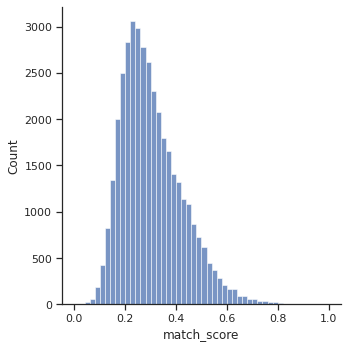

In [62]:
sns.displot(data=df, 
            x="match_score", 
            bins=50
           );

In [68]:
# df1 = pd.read_csv(OUTPUT_SCORE_PATH)
df1 = df.merge(df_outputs[['Output UUID', 'Output Year', 'ASJC Scopus Subject Areas', 'Administering Org Unit', 'Journal Title',
             'Administering Org Unit - Primary', 'Journal Citation Report (JCR) Q1', 'Journal Impact Factor - 2 Year', 'Author List']], on='Output UUID')

In [69]:
df1['keywords'] = df1['Output Keywords'].apply(lambda x: x.split(';') if isinstance(x, str) else "")

### Wordclouds

==> Rows selected: 110


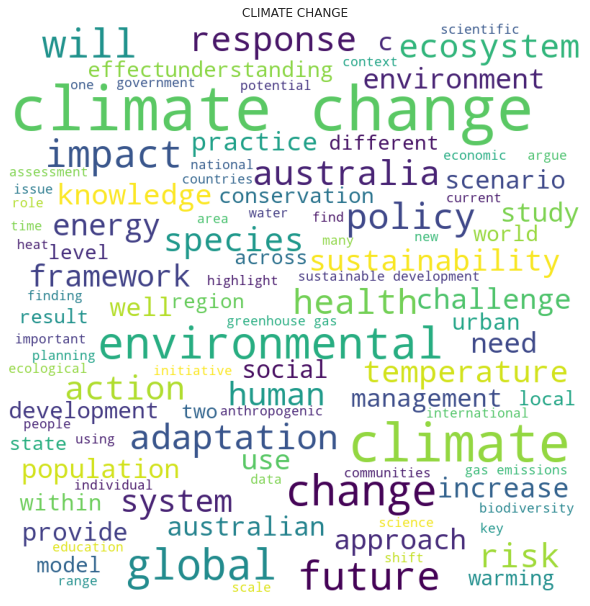

In [70]:
custom_stopwords = ['article', 'research', 'paper', 'S', 'theoretical']
wordcloud(d=df, title=TITLE, threshold=THRESHOLD, custom_stopwords=custom_stopwords)

### Authors and Journals

In [71]:
df1 = df1.loc[df1.match_score >= THRESHOLD, :]
print(df1.shape)

(110, 17)


In [72]:
df1.head()

,Output UUID,Output Abstract,Output Title,Output Keywords,body,seq_length,sent,match_score,Output Year,ASJC Scopus Subject Areas,Administering Org Unit,Journal Title,Administering Org Unit - Primary,Journal Citation Report (JCR) Q1,Journal Impact Factor - 2 Year,Author List,keywords
0,9f45a6bb-2921-401e-99f9-d199f57bab54,Climate change is a key societal and economic ...,A multilevel analysis of climate change inaction,Adaptive cycle; business model transformation;...,A multilevel analysis of climate change inacti...,1480,[A multilevel analysis of climate change inact...,1.000000,2020.0,"Geography, Planning and Development; Managemen...",Human Geography,Australasian Journal of Environmental Management,Dean Faculty of Arts,NaN,1.833,"Mishra, Kirti; Neesham, Cristina; Coghill, Ken...","[Adaptive cycle, business model transformatio..."
1,5f098dc2-09b5-4107-b441-fb18843d7cfe,Changes in natural hazards related to climate ...,"A conceptual framework for climate change, hea...",NaN,"A conceptual framework for climate change, hea...",1404,"[A conceptual framework for climate change, he...",0.953132,2018.0,"Public Health, Environmental and Occupational ...",Monash Sustainable Development Institute,Public Health Research & Practice,Office of the DVC (Research) & Senior VP,NaN,NaN,"Boylan, Sinead; Beyer, Kathleen; Schlosberg, D...",
2,bb83a076-d66b-4ef6-a05f-c7aff034c0d5,"Increasing discussion is occurring, in both th...",The risk of catastrophic climate change,BECCS; Catastrophic climate change; Climate em...,The risk of catastrophic climate change. Incre...,1008,"[The risk of catastrophic climate change, Incr...",0.950208,2021.0,Business and International Management; Develop...,Department of Design,Futures,Dean Faculty of Art Des & Architecture,NaN,3.788,"Moriarty, Patrick; Honnery, Damon","[BECCS, Catastrophic climate change, Climate..."
3,a86083cb-3e92-4a4e-b86d-efe1d7a3fbce,Climate plays an important role in human healt...,The MJA-lancet countdown on health and climate...,NaN,The MJA-lancet countdown on health and climate...,1819,[The MJA-lancet countdown on health and climat...,0.939640,2018.0,Medicine(all),Dept of Epidemiology & Prev Med Alf Hosp,The Medical Journal of Australia,Dean Faculty of Med Nursing & Health Sci,Q1,5.332,"Zhang, Ying; Beggs, Paul J.; Bambrick, Hilary;...",
4,eabde5ae-a964-4581-91b1-08ffec532849,The MJA–Lancet Countdown on health and climate...,The 2021 report of the MJA–Lancet Countdown on...,Climate change; Health communication; Health f...,The 2021 report of the MJA–Lancet Countdown on...,1937,[The 2021 report of the MJA–Lancet Countdown o...,0.936180,2021.0,Medicine(all),Dept of Epidemiology & Prev Med Alf Hosp,The Medical Journal of Australia,Dean Faculty of Med Nursing & Health Sci,Q1,12.776,"Beggs, Paul J.; Zhang, Ying; McGushin, Alice; ...","[Climate change, Health communication, Healt..."


In [73]:
df1['Journal Impact Factor - 2 Year'].describe()

count     81.000000
mean      10.269284
std       23.678570
min        0.773000
25%        3.149000
50%        5.005000
75%        7.738000
max      202.731000
Name: Journal Impact Factor - 2 Year, dtype: float64

In [74]:
def filter_papers(df,
                min_if=1.0,
                q1_only=True):
    # impact factor
    df = df.loc[df['Journal Impact Factor - 2 Year'] >= min_if, :]
    # Q1
    if q1_only:
        df = df.loc[df['Journal Citation Report (JCR) Q1'] == 'Q1', :]
    
    df.sort_values('Journal Impact Factor - 2 Year', ascending=False, inplace=True)
    
    return df

In [75]:
d1 = filter_papers(df1, 
                  min_if=1.0,
                  q1_only=True,
                 )
d1.shape

(56, 17)

In [76]:
# note: one row per author
d1 = d1.merge(df_authors, on="Output UUID")

Internal ONLY

In [77]:
d1 = d1.loc[d1['Author Type (At the time)'] == "Internal", :]

In [78]:
d1.head()

,Output UUID,Output Abstract,Output Title,Output Keywords,body,seq_length,sent,match_score,Output Year,ASJC Scopus Subject Areas,...,Author List,keywords,Author Order Number,Author Full Name,Author Type (At the time),Internal Author Org Unit (At the Time),Internal Author Org Unit - Primary (At the Time),Author External Org Name,External Org Country,External Org International Indicator
1,4c86c2e8-de93-43df-ab76-98e6344e87cb,"Heat extremes (ie, heatwaves) already have a s...",Reducing the health effects of hot weather and...,NaN,Reducing the health effects of hot weather and...,1332,[Reducing the health effects of hot weather an...,0.797011,2021.0,Medicine(all),...,"Jay, Ollie; Capon, Anthony; Berry, Peter; Brod...",,2,"Capon, Anthony Guy",Internal,Monash Sustainable Development Institute,Office of the DVC (Research) & Senior VP,NaN,NaN,NaN
2,4c86c2e8-de93-43df-ab76-98e6344e87cb,"Heat extremes (ie, heatwaves) already have a s...",Reducing the health effects of hot weather and...,NaN,Reducing the health effects of hot weather and...,1332,[Reducing the health effects of hot weather an...,0.797011,2021.0,Medicine(all),...,"Jay, Ollie; Capon, Anthony; Berry, Peter; Brod...",,2,"Capon, Anthony Guy",Internal,NaN,NaN,University of Sydney,Australia,Australia
49,2ef841ae-74a0-4d53-9501-30591013f857,We present two narratives on the future of Ant...,Choosing the future of Antarctica,NaN,Choosing the future of Antarctica. We present ...,688,"[Choosing the future of Antarctica, We present...",0.854140,2018.0,General,...,"Rintoul, S. R.; Chown, S. L.; DeConto, R. M.; ...",,2,"Chown, Steven Loudon",Internal,Sch of Biological Sciences,Dean Faculty of Science,NaN,NaN,NaN
64,e29596b9-da96-4b51-b507-e78c23591d61,"The El Niño-Southern Oscillation (ENSO), which...",Pantropical climate interactions,decadal variation; decadal climate; climate pr...,Pantropical climate interactions. The El Niño-...,897,"[Pantropical climate interactions, The El Niño...",0.812206,2019.0,General,...,"Cai, Wenju; Wu, Lixin; Lengaigne, Matthieu; Li...","[decadal variation, decadal climate, climate...",5,"McGregor, Shayne",Internal,Sch of Earth Atmosphere & Environment,Dean Faculty of Science,NaN,NaN,NaN
78,e29596b9-da96-4b51-b507-e78c23591d61,"The El Niño-Southern Oscillation (ENSO), which...",Pantropical climate interactions,decadal variation; decadal climate; climate pr...,Pantropical climate interactions. The El Niño-...,897,"[Pantropical climate interactions, The El Niño...",0.812206,2019.0,General,...,"Cai, Wenju; Wu, Lixin; Lengaigne, Matthieu; Li...","[decadal variation, decadal climate, climate...",16,"Dommenget, Dietmar",Internal,Sch of Earth Atmosphere & Environment,Dean Faculty of Science,NaN,NaN,NaN


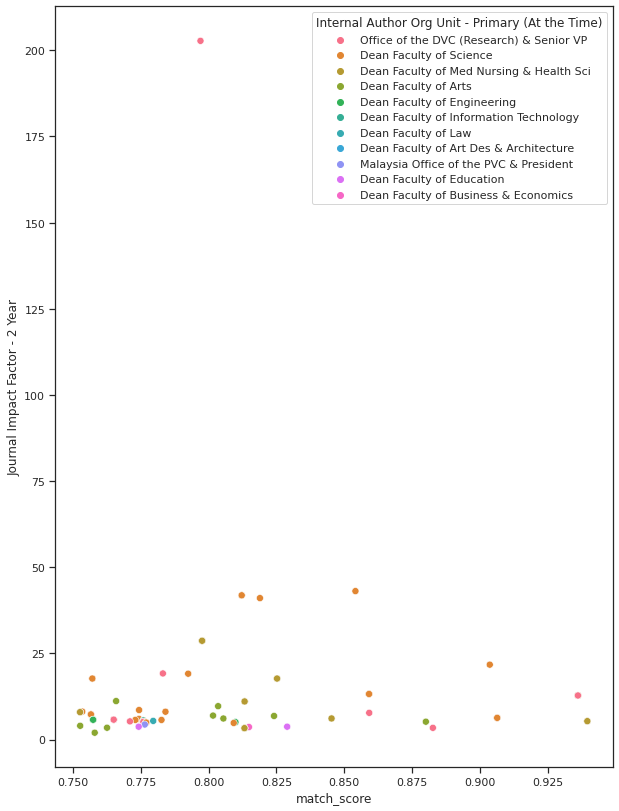

In [79]:
sns.scatterplot(
    data=d1, 
    y="Journal Impact Factor - 2 Year", 
    x="match_score", 
    hue="Internal Author Org Unit - Primary (At the Time)",
    s=50
);

In [80]:
d1.rename(columns={'match_score': 'Match Score'}, inplace=True)

In [81]:
d1.drop_duplicates(['Output Title', 'Author Full Name', 'Journal Title'], inplace=True)
d1.shape

(68, 25)

In [82]:
import plotly.express as px
fig = px.bar(d1, y='Author Full Name', x='Journal Impact Factor - 2 Year',
             text_auto='.2s',
             title=f"{TITLE} - Top Researchers (> {THRESHOLD})",
             hover_data=['Output Title', 
                         'Author Full Name',  
                         'Internal Author Org Unit - Primary (At the Time)',
                         'Journal Title'
                        ], 
             color='Match Score',
             orientation='h',
             template='plotly_white',
             # width=800
            )
fig.update_layout(yaxis={'categoryorder':'mean descending'}) # add only this line
fig.show()

In [84]:
import plotly.express as px
d = d1.groupby(['Author Full Name']).mean().reset_index()
d.rename(columns={'Match Score': 'Average Match Score'}, inplace=True)
fig = px.bar(d,
             y='Author Full Name', x='Journal Impact Factor - 2 Year',
             title=f"{TITLE} - Top Researchers (> {THRESHOLD})",
             color='Average Match Score',
             orientation='h',
             template='plotly_white'
             # height=400
            )
fig.update_layout(yaxis={'categoryorder':'mean descending'}) # add only this line
fig.show()

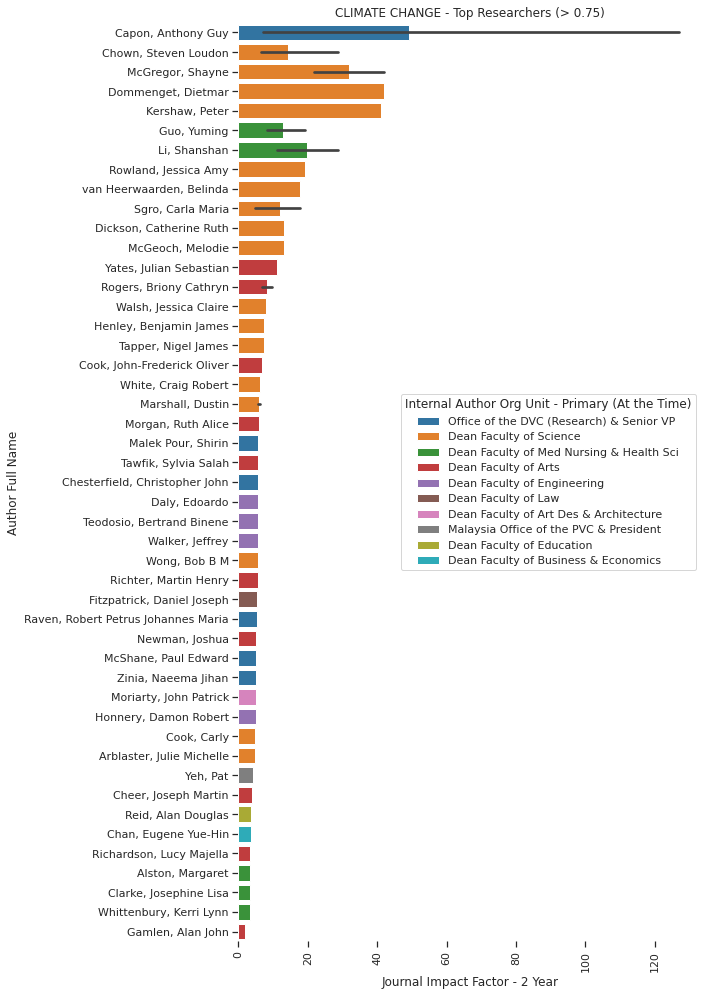

In [85]:
plot = sns.barplot(data=d1, 
            y='Author Full Name', 
            x="Journal Impact Factor - 2 Year",
            hue="Internal Author Org Unit - Primary (At the Time)",
            dodge=False,
            palette="tab10"
            )
# Add a legend and informative axis label
# plot.legend(ncol=2, loc="lower right", frameon=True)
plot.set(
        title=f"{TITLE} - Top Researchers (> {THRESHOLD})",
        )
sns.despine(left=True, bottom=True)
plt.setp(plot.get_xticklabels(), rotation=90);
plt.tight_layout()
plt.savefig(OUTPUT_PLOT_PATH, bbox_inches='tight')

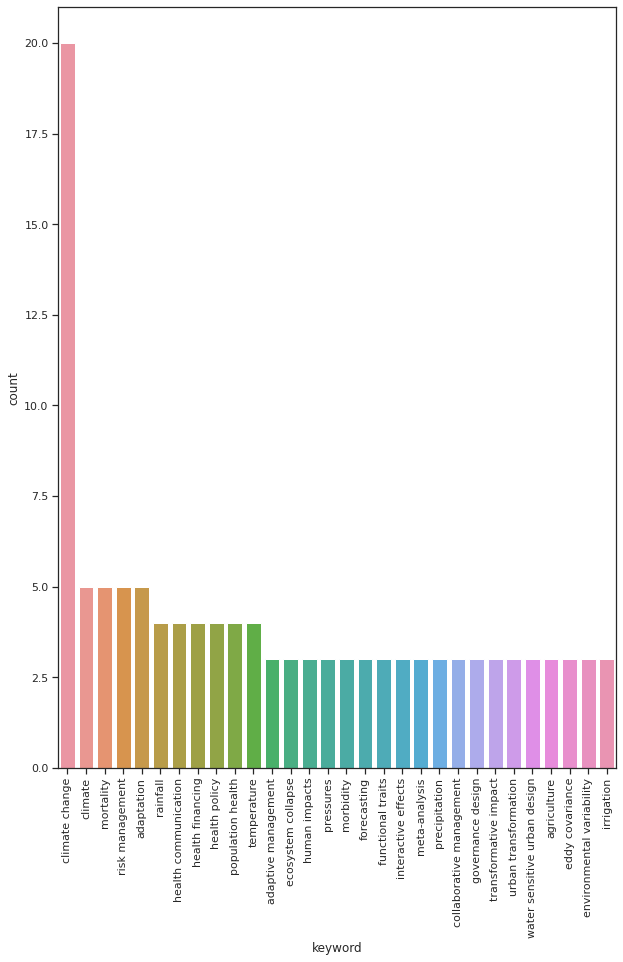

In [86]:
keywords = list(itertools.chain(*d1.keywords.tolist()))
keywords = [x.lower().strip() for x in keywords]
count = Counter(keywords)

df_keywords = pd.DataFrame.from_dict(dict(count.most_common(30)), orient='index').reset_index()
df_keywords.rename(columns={'index': 'keyword', 0: 'count'}, inplace=True)

plot = sns.barplot(data=df_keywords, x="keyword", y="count");
plt.setp(plot.get_xticklabels(), rotation=90);

## Neural Topic Modeling (NTM)

### Cross-validation
- Use Topic Coherence (TC) and Topic Diversity (TD) to automatically find the optimal clusters (i.e. topics)
- NB: Use TC as the primary metric than TC * TD -- as it yields better results

In [108]:
# df1 = pd.read_csv(OUTPUT_SCORE_PATH)
df1 = df.merge(df_outputs[['Output UUID', 'Output Year', 'ASJC Scopus Subject Areas', 'Administering Org Unit', 'Journal Title',
             'Administering Org Unit - Primary', 'Journal Citation Report (JCR) Q1', 'Journal Impact Factor - 2 Year', 'Author List']], on='Output UUID')

In [109]:
def topic_diversity(topics, topk=10):
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than '+str(topk))
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:topk]))
        puw = len(unique_words) / (topk * len(topics))
        return puw

In [110]:
df1['body'] = df1.sent.apply(lambda x: join_sents(x))

In [111]:
df1[:3].body.tolist()

['A multilevel analysis of climate change inaction. Climate change is a key societal and economic challenge. Despite widespread recognition for the need for urgent action on climate change, transformation to a zero carbon economy is still elusive. While there are detailed accounts of organisational responses to climate change impacts, little is known about climate change inaction. We adopt the theoretical framework of resilience in social-ecological systems to explore the change processes needed to overcome climate change inaction. Through an in-depth case study of an Australian energy company, we identify the impediments to climate change action due to rigidity and scarcity traps at three levels: micro (organisation), meso (industry), and macro (government). These traps inhibit transformation from a fossil fuel regime to a renewable energy regime. Our study contributes to a multi-level theory of organisational inaction on climate change by identifying specific causal factors that erod

Run CV

In [ ]:
cv_scores = []

for threshold in THRESHOLDS:

    for min_cluster_size in MIN_CLUSTER_GRID_SIZE:

        for n_neighbour in N_NEIGHBOURS_GRID_SIZE:

            try:
                umap_model = UMAP(n_neighbors=n_neighbour, n_components=N_COMPONENTS, metric='cosine', low_memory=False)
                hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', prediction_data=True)
                vectorizer_model = CountVectorizer(ngram_range=N_GRAM_RANGE, 
                                                stop_words="english", 
                                                token_pattern=TOKEN_PATTERN, 
                                                max_features=MAX_FEATURES
                                                )
                
                # filter based on threshold ONLY
                docs = df1.loc[df1.match_score >= threshold, 'body'].tolist()

                topic_model = BERTopic(verbose=True, 
                                    vectorizer_model=vectorizer_model,
                                    umap_model=umap_model,
                                    hdbscan_model=hdbscan_model
                                    )
                topics, _ = topic_model.fit_transform(docs)

                # Preprocess Documents
                documents = pd.DataFrame({"Document": docs,
                                        "ID": range(len(docs)),
                                        "Topic": topics})
                documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
                cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

                # Extract vectorizer and analyzer from BERTopic
                vectorizer = topic_model.vectorizer_model
                analyzer = vectorizer.build_analyzer()

                # Extract features for Topic Coherence evaluation
                words = vectorizer.get_feature_names()
                tokens = [analyzer(doc) for doc in cleaned_docs]
                dictionary = corpora.Dictionary(tokens)
                corpus = [dictionary.doc2bow(token) for token in tokens]
                topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                            for topic in range(len(set(topics))-1)]
                print(f"Topic words: {topic_words}")

                # Evaluate
                coherence_model = CoherenceModel(topics=topic_words, 
                                                texts=tokens, 
                                                corpus=corpus,
                                                dictionary=dictionary, 
                                                coherence='c_v') # c_v c_npmi
                coherence = coherence_model.get_coherence()
                diversity = topic_diversity(topic_words, N_WORDS)

                cv_scores.append(
                    dict(
                        n_docs=len(docs),
                        n_topics=len(topic_words),
                        min_cluster_size=min_cluster_size,
                        n_neighbours=n_neighbour,
                        topic_coherence_score=coherence,
                        topic_diversity_score=diversity,
                        topic_words=topic_words,
                        threshold=threshold
                    )
                )
                print(f"[ no_docs / no_topics / threshold / n_neighbour / min_cluster_size / diversity / coherence] = [ {len(docs)} / {len(topic_words)} /  {threshold} / {n_neighbour} / {min_cluster_size} / {diversity:.4f} / {coherence:.4f}]")

            except Exception as e:
                print(e)
                cv_scores.append(
                    dict(
                        n_docs=len(docs),
                        n_topics=len(topic_words),
                        min_cluster_size=min_cluster_size,
                        n_neighbours=n_neighbour,
                        topic_coherence_score=None,
                        topic_diversity_score=None,
                        topic_words=topic_words,
                        threshold=threshold
                    )
                )

For NPMI,

> Pointwise mutual information can be normalized between [-1,+1] resulting in -1 (in the limit) for never occurring together, 0 for independence, and +1 for complete co-occurrence [[source](https://en.wikipedia.org/wiki/Pointwise_mutual_information)]

In [ ]:
df_cv = pd.DataFrame(cv_scores)
df_cv.dropna(inplace=True)
df_cv['tc_td'] = df_cv.apply(lambda x: x.topic_coherence_score * x.topic_diversity_score, axis=1)
print(df_cv.shape)

(36, 9)


In [ ]:
df_cv.to_csv(OUTPUT_TOPIC_SCORES_PATH, index=False)

### Run w/ optimal hyperparams

In [97]:
# df_cv = pd.read_csv(OUTPUT_TOPIC_SCORES_PATH)
# df_cv['topic_words'] = df_cv.topic_words.apply(lambda x: ast.literal_eval(x))

In [98]:
df_cv.head()

,n_docs,n_topics,min_cluster_size,n_neighbours,topic_coherence_score,topic_diversity_score,topic_words,threshold,tc_td
0,799,27,5,5,0.525369,0.837037,"[[conservation, species, climate, changes, man...",0.6,0.439753
1,799,30,5,10,0.527111,0.900000,"[[education, students, policy, learning, young...",0.6,0.474400
2,799,25,5,15,0.579328,0.880000,"[[education, students, policy, young, learning...",0.6,0.509809
3,799,23,5,20,0.580791,0.869565,"[[education, policy, students, learning, young...",0.6,0.505036
4,799,5,10,5,0.701946,0.800000,"[[research, environmental, sustainability, dev...",0.6,0.561557


In [99]:
df_cv[df_cv.n_topics > 1].sort_values(['topic_coherence_score', 'n_topics'], ascending=False)

,n_docs,n_topics,min_cluster_size,n_neighbours,topic_coherence_score,topic_diversity_score,topic_words,threshold,tc_td
14,799,8,20,15,0.727022,0.900000,"[[urban, water, sustainability, environmental,...",0.6,0.654320
15,799,8,20,20,0.725532,0.900000,"[[urban, water, sustainability, environmental,...",0.6,0.652979
8,799,4,15,5,0.719087,0.750000,"[[environmental, energy, research, development...",0.6,0.539315
13,799,9,20,10,0.710696,0.911111,"[[education, policy, students, learning, young...",0.6,0.647523
4,799,5,10,5,0.701946,0.800000,"[[research, environmental, sustainability, dev...",0.6,0.561557
6,799,11,10,15,0.697502,0.872727,"[[education, policy, students, learning, young...",0.6,0.608729
12,799,4,20,5,0.697349,0.750000,"[[environmental, research, energy, policy, sus...",0.6,0.523012
10,799,9,15,15,0.690227,0.866667,"[[education, policy, students, learning, healt...",0.6,0.598197
11,799,11,15,20,0.685965,0.890909,"[[education, policy, students, learning, young...",0.6,0.611132
7,799,12,10,20,0.676123,0.900000,"[[education, policy, students, learning, young...",0.6,0.608510


In [100]:
# Get top-5 topic words
top_topics = df_cv[df_cv.n_topics > 1].sort_values(['topic_coherence_score', 'n_topics'], ascending=False).iloc[:5].topic_words.tolist()

In [101]:
for topic in top_topics:
    print("-"*80)
    for i, words in enumerate(topic):
        print(f"{i+1}: " + ", ".join(words[:5]))

--------------------------------------------------------------------------------
1: urban, water, sustainability, environmental, transitions
2: education, policy, students, learning, young
3: climate, variability, model, changes, warming
4: conservation, species, biodiversity, management, ecosystem
5: energy, emissions, carbon, renewable, renewable energy
6: species, thermal, change, climate, temperature
7: health, mortality, climate change, climate, change
8: disaster, resilience, disasters, community, risk
--------------------------------------------------------------------------------
1: urban, water, sustainability, environmental, sustainable
2: education, policy, students, learning, research
3: climate, variability, model, changes, rainfall
4: conservation, species, biodiversity, management, practitioners
5: energy, emissions, carbon, renewable, renewable energy
6: species, thermal, change, climate, temperature
7: health, mortality, climate, climate change, change
8: disaster, res

Optimal clusters

In [112]:
optim = df_cv[df_cv.topic_coherence_score.max() == df_cv.topic_coherence_score]

n_neighbour = optim.n_neighbours.item()
min_cluster_size = optim.min_cluster_size.item()
threshold = optim.threshold.item()

print(f"==> Optimal Hyperparameters: n_neighbour: {n_neighbour} / min_cluster_size: {min_cluster_size} / threshold: {threshold}")

==> Optimal Hyperparameters: n_neighbour: 15 / min_cluster_size: 20 / threshold: 0.6


In [113]:
d = df1[df1.match_score >= threshold]
docs = d.body.tolist()
print(len(docs))
embeddings = model.encode(docs, show_progress_bar=True)

umap_model = UMAP(random_state=SEED, n_neighbors=n_neighbour, n_components=N_COMPONENTS, metric='cosine', low_memory=False)
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', prediction_data=True)
vectorizer_model = CountVectorizer(ngram_range=N_GRAM_RANGE, 
                        stop_words="english", 
                        token_pattern=TOKEN_PATTERN, 
                        max_features=MAX_FEATURES
                        )
# train topic model
topic_model = BERTopic(verbose=True, 
                vectorizer_model=vectorizer_model,
                umap_model=umap_model,
                hdbscan_model=hdbscan_model
                ).fit(docs, embeddings)

reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.get_topics()

799


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

2022-12-08 04:09:51,931 - BERTopic - Reduced dimensionality
2022-12-08 04:09:51,965 - BERTopic - Clustered reduced embeddings


{-1: [('climate', 0.027458772212270718),
  ('environmental', 0.020319011297456554),
  ('change', 0.019625388953880378),
  ('data', 0.015482414690905484),
  ('impacts', 0.01485991030845531),
  ('human', 0.014528776047413035),
  ('climate change', 0.01452792130616595),
  ('health', 0.014325970095734449),
  ('research', 0.014127225441926126),
  ('species', 0.014001970707118309)],
 0: [('urban', 0.03849616799500582),
  ('water', 0.03704771754201688),
  ('sustainability', 0.029432756688790553),
  ('environmental', 0.02768565701176443),
  ('sustainable', 0.02366875345499014),
  ('research', 0.022367411300487812),
  ('social', 0.020796780411095096),
  ('development', 0.020629504974897243),
  ('transitions', 0.018246366606335513),
  ('cities', 0.017814067874810154)],
 1: [('education', 0.05580307851850506),
  ('policy', 0.03582371193248456),
  ('students', 0.032743034539331986),
  ('young', 0.029516289154538123),
  ('learning', 0.02950170706976225),
  ('research', 0.027828206300355176),
  ('he

In [114]:
d['topic'] = topic_model.topics_

### Generate vis

Set custom labels

In [ ]:
# custom_labels = {0: "Urban resource sustainability and governance", 1: "The mobile city", 2: "Online in the city", 3: "Rural Health Care and Support Services", 4: "Disaster Resilience in communities"}
# topic_model.set_topic_labels(custom_labels)
# print(topic_model.custom_labels_)
# orig_labels = {k: ", ".join(v.split('_')[1:]) for k, v in topic_model.topic_labels_.items()}
# stop_words = ['article', 'research', 'study', 'paper']
# temp = {}
# for k, v in orig_labels.items():
#     words = []
#     for l in v.split(', '):
#         if l not in stop_words:
#             words.append(l)
    
#     temp[k] = ', '.join(words)

# orig_labels = temp
# del orig_labels[-1]
# print(orig_labels)
# df['topic'] = topic_model.topics_
# df['topic'] = df.topic.map(orig_labels)

In [115]:
d['Journal Impact Factor - 2 Year'].fillna(0.0, inplace=True)

In [116]:
d.topic.fillna("", inplace=True)

In [117]:
d.topic

0      0
1      6
2     -1
3      6
4      6
      ..
794   -1
795   -1
796    0
797    3
798    2
Name: topic, Length: 799, dtype: int64

In [118]:
d['label'] = '"' + d['Output Title'] + '"' + ', ' + d['Journal Title'] + ' (I.F=' +  d["Journal Impact Factor - 2 Year"].astype('str') + ') '

In [119]:
d.label

0      "A multilevel analysis of climate change inact...
1      "A conceptual framework for climate change, he...
2      "The risk of catastrophic climate change", Fut...
3      "The MJA-lancet countdown on health and climat...
4      "The 2021 report of the MJA–Lancet Countdown o...
                             ...                        
794    "Bouncing back", Journal of Management (I.F=8....
795    "Development of the VTUF-3D v1.0 urban micro-c...
796    "Transmigrants experiences of recognitional (i...
797    "Rock removal associated with agricultural int...
798    "Long-term data reveal highly-variable metabol...
Name: label, Length: 799, dtype: object

In [120]:
d['label'] = d.apply(lambda x: f'{x.label}; [{x.topic}]' if x.topic != "" else x.label, axis=1)

In [121]:
d.label

0      "A multilevel analysis of climate change inact...
1      "A conceptual framework for climate change, he...
2      "The risk of catastrophic climate change", Fut...
3      "The MJA-lancet countdown on health and climat...
4      "The 2021 report of the MJA–Lancet Countdown o...
                             ...                        
794    "Bouncing back", Journal of Management (I.F=8....
795    "Development of the VTUF-3D v1.0 urban micro-c...
796    "Transmigrants experiences of recognitional (i...
797    "Rock removal associated with agricultural int...
798    "Long-term data reveal highly-variable metabol...
Name: label, Length: 799, dtype: object

In [122]:
if_list = d['Journal Impact Factor - 2 Year'].tolist() # get impact factors
assert len(docs) == len(if_list)

Get proper marker size based on I.F.

In [123]:
if_lists = []
for i in if_list:
    if i == 0.0:
        if_lists.append(1)
    else:
        if_lists.append(math.ceil(i))

if_lists = [x + 5 for x in if_lists] # if_lists = [math.log2(x) + 5 for x in if_lists]

Generate visualization

In [124]:
titles = d['label'].tolist() # as hover text labels
assert len(docs) == len(titles)
info_text = "Data source: PURE | Powered by Monash SoDa Labs"

fig = visualize_documents(topic_model,
                        title=TITLE.lower().capitalize(),
                        if_list=if_lists,
                        docs=docs,
                        reduced_embeddings=reduced_embeddings,
                        hover_text_labels=titles,
                        stop_words=['article', 'research', 'study', 'paper'],
                        custom_labels=True,
                        info_text=info_text,
                        template="plotly_dark", # simple_white
                        )
fig.write_html(OUTPUT_VIS_PATH) # export to HTML
fig

EOF